# Watson OpenScale SHAP Tree metric for regression model

The notebook will train House Price regression model using XGBoost, generate local and global explanations using SHAP tree explainer and provide insights into model behaviour.

### Contents
- [Setup](#Setup)
- [Model building and evaluation](#model)
- [OpenScale configuration](#openscale)
- [Compute SHAP explanations](#shap)
- [Visualize the explanations](#visualize)

**Note:** This notebook requires service credentials of Watson OpenScale.

## Setup

### Package Installation

In [ ]:
!pip install --upgrade pyspark==3.3.1 | tail -n 1
!pip install --upgrade ibm-watson-openscale --no-cache | tail -n 1
!pip install --upgrade ibm-metrics-plugin --no-cache | tail -n 1
!pip install matplotlib==3.2.2
!pip install xgboost
!pip install numpy==1.23.5

**Action: Restart the kernel!**

### Configure Credentials

In [1]:
import warnings
warnings.filterwarnings("ignore")

Provide your IBM Watson OpenScale credentials in the following cell:

In [2]:
WOS_CREDENTIALS = {
    "url": "<cluster url>",
    "username": "",
    "password": "",
    "instance_id": "<service instance id>"
}

## Model building and evaluation <a name="model"></a>

In this section you will learn how to train regression model using XGBoost, run prediction and evaluate its output.

### Load the training data from github

In [3]:
!rm house_price_regression.csv
!wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/house_price/house_price_regression.csv

--2024-08-07 13:24:36--  https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/house_price/house_price_regression.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185379 (181K) [text/plain]
Saving to: ‘house_price_regression.csv’

house_price_regress 100%[===================>] 181.03K  --.-KB/s    in 0.04s   

2024-08-07 13:24:36 (4.81 MB/s) - ‘house_price_regression.csv’ saved [185379/185379]



In [4]:
import pandas as pd
import numpy as np
data_df = pd.read_csv("house_price_regression.csv")

### Explore data

In [5]:
data_df.head()

,Id,MSSubClass,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleCondition,SalePrice
0,1,60,7,5,2003,2003,196.0,706,0,150,...,61,0,0,0,0,0,2,2008,Normal,208500
1,2,20,6,8,1976,1976,0.0,978,0,284,...,0,0,0,0,0,0,5,2007,Normal,181500
2,3,60,7,5,2001,2002,162.0,486,0,434,...,42,0,0,0,0,0,9,2008,Normal,223500
3,4,70,7,5,1915,1970,0.0,216,0,540,...,35,272,0,0,0,0,2,2006,Abnorml,140000
4,5,60,8,5,2000,2000,350.0,655,0,490,...,84,0,0,0,0,0,12,2008,Normal,250000


### Create a model

In this section you will learn how to:

- Prepare data for training a model
- Train a model
- Evaluate a model

#### Import required libraries

In [6]:
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer

#### Splitting the data into train and test

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

data_df.dropna(axis=0, subset=["SalePrice"], inplace=True)
label = data_df.SalePrice
feature_data = data_df.drop(["Id","SalePrice"], axis=1).select_dtypes(exclude=["object"])
X_train, X_test, y_train, y_test = train_test_split(feature_data, label.values, test_size=0.25, random_state=321)

my_imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
X_train = my_imputer.fit_transform(X_train)
X_test = my_imputer.transform(X_test)

#### Train a model

In [8]:
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer

model=XGBRegressor(eval_metric=['error'])
model.fit(X_train, y_train, 
             eval_set=[(X_test, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['error'],
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

#### Evaluate the model

In [9]:
predictions = model.predict(X_test)
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 20837.653510273973


## Openscale Configuration <a name="openscale"></a>

Import the necessary libraries and set up OpenScale Python client.

In [10]:
from ibm_watson_openscale import APIClient as OpenScaleAPIClient
from ibm_cloud_sdk_core.authenticators import CloudPakForDataAuthenticator

authenticator = CloudPakForDataAuthenticator(
    url=WOS_CREDENTIALS["url"],
    username=WOS_CREDENTIALS["username"],
    password=WOS_CREDENTIALS["password"],
    disable_ssl_verification=True
)

client = OpenScaleAPIClient(
    service_url=WOS_CREDENTIALS["url"],
    service_instance_id=WOS_CREDENTIALS["instance_id"],
    authenticator=authenticator
)

client.version

'3.0.40'

## SHAP explanations <a name="shap"></a>

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. See [paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) for technical details of the algorithm.

The Shapley value is the average marginal contribution of a feature value across all possible feature coalitions.

SHAP assigns each feature an importance value for a particular prediction which is called SHAP value. The SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained.

### Prepare input to compute SHAP explanations

#### Create spark session

In [11]:
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.appName("TestMetrics").getOrCreate()

24/08/07 13:24:45 WARN Utils: Your hostname, Nelwins-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.103 instead (on interface en0)
24/08/07 13:24:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/07 13:24:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/08/07 13:24:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/08/07 13:24:46 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/08/07 13:24:46 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


#### Create configuration for computing the SHAP metric

Set the below properties in the configuration

- **problem_type** : The model problem type. Possible values are 'binary', 'multiclass', 'regression'
- **input_data_type**: The input data type. Supported value is 'structured'
- **feature_columns**: The list of feature columns
- **categorical_columns**: The list of categorical columns
- **explainability**: The expainability metrics configuration

Optional parameters for shap kernel metric

- **explanation_types**: The list of explanation types to be generated. Supported values are **global**, **local**. By default both the local and global explanations are generated. Default value is **["global", "local"]**
- **aggregation_methods**: The list of aggregation methods used to combine the shap values of all the datapoints to get the global explanation. Supported values are **mean_abs**(mean of absolute shap values), **max_abs**(max od absolute shap values), **mean_sq**(mean of squares of shap values). Default value is **["mean_abs"]**

In [12]:
from ibm_metrics_plugin.common.utils.constants import ExplainabilityMetricType, ProblemType, InputDataType, MetricGroupType
from ibm_metrics_plugin.metrics.explainability.entity.constants import ShapAlgorithm, ShapAggregationMethod, ExplanationType

configuration={
    "configuration": {
        "problem_type": ProblemType.REGRESSION.value,
        "input_data_type": InputDataType.STRUCTURED.value,
        "feature_columns": list(feature_data.columns),
        "categorical_columns": [],
        MetricGroupType.EXPLAINABILITY.value : {
            "metrics_configuration": {
                ExplainabilityMetricType.SHAP.value : {
                    "algorithm": ShapAlgorithm.TREE.value
                    # "explanation_types": [ExplanationType.GLOBAL.value]
                    # "aggregation_methods": [ShapAggregationMethod.MEAN_ABS.value, ShapAggregationMethod.MAX_ABS.value, ShapAggregationMethod.MEAN_SQ.value]
                }
            }
        }
    }
}

### Compute explanations

Compute the explanations for the test data. The test data could be a spark dataframe or pandas dataframe. Here we use a pandas dataframe.

In [13]:
metrics_result = client.ai_metrics.compute_metrics(spark=spark, 
                                            configuration=configuration, 
                                            data_frame=pd.DataFrame(X_test, columns=list(feature_data.columns)), 
                                            model=model)

## Visualize the explanations <a name="visualize"></a>

### Convert metrics result to shap explanations object

Convert the metrics result dict to shap explanations object, which can be used for plotting the explanations

In [14]:
shap_explanations=client.ai_metrics.transform_result(metrics_result=metrics_result, 
                                                     metric_group_type=MetricGroupType.EXPLAINABILITY.value, 
                                                     metric_type=ExplainabilityMetricType.SHAP.value)

### Visualize the local explanation

Plot the local explanation for the first data point.

In [15]:
shap=shap_explanations.get("shap")
shap.initjs()

Get the local explanations

In [16]:
local_explanations = shap_explanations.get("local")
if local_explanations:
    local_explanations = local_explanations[0]

**Visualize the explanation for the first datapoint prediction**

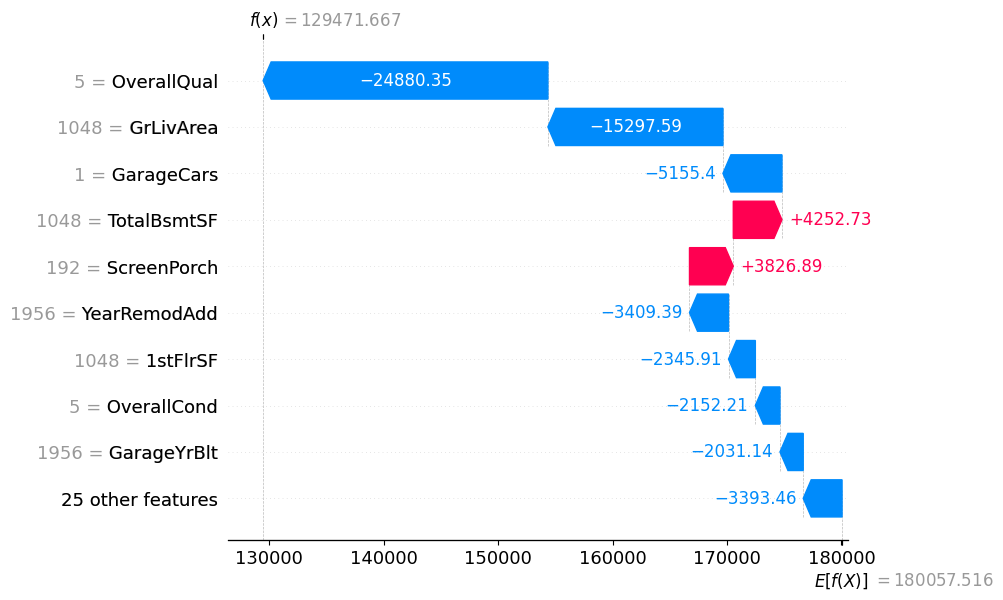

In [17]:
if local_explanations:
    shap.plots.waterfall(local_explanations[0])

The above explanation shows the features contributing to the model output from the base value (the average model output over the training data) to the model output of this data point. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

### Visualize the summary of explanations

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals for example that a high OverallQual value increases the house price.

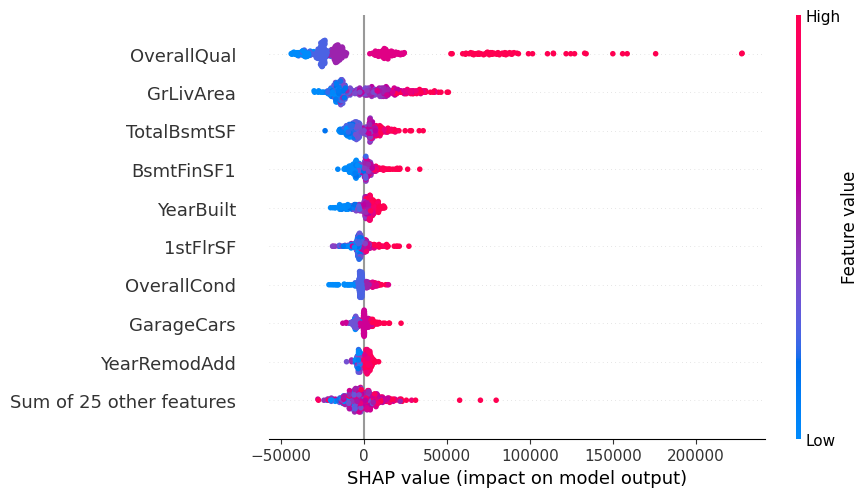

In [18]:
if local_explanations:
    shap.plots.beeswarm(local_explanations)

The generated global explanations(mean_abs or max_abs or mean_sq) could be plotted as a bar plot to understand the overall importance of features.

In the below plot the mean absolute shap values are plotted.

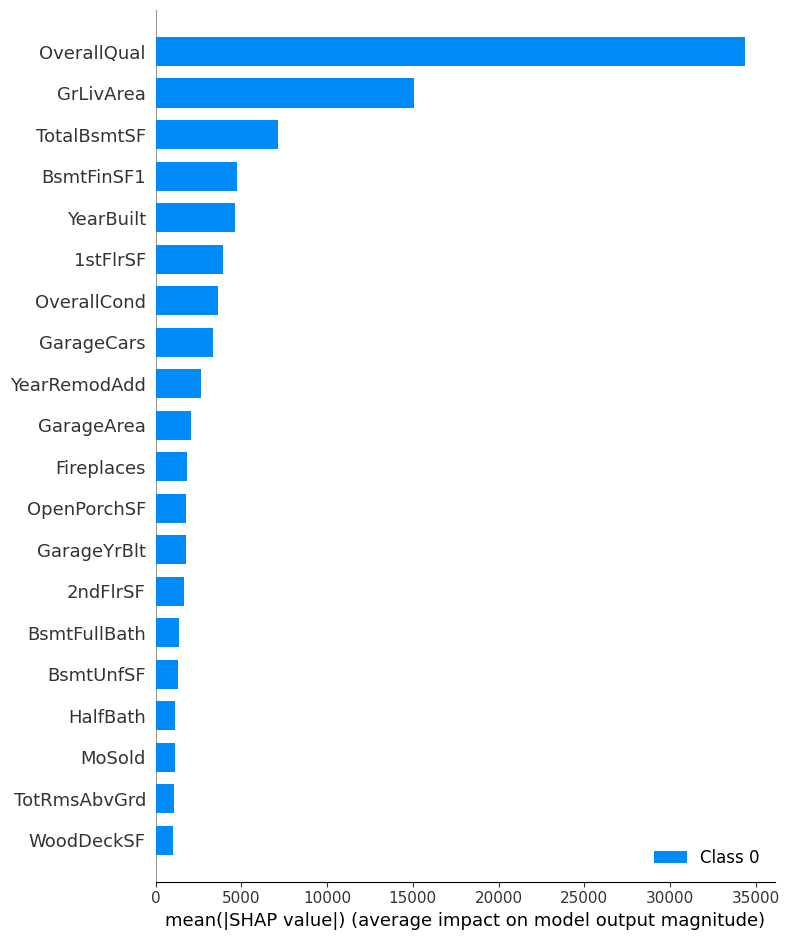

In [19]:
global_explanations = shap_explanations.get("global")
if global_explanations:
    global_explanation = global_explanations.get("mean_abs")
    shap.summary_plot(global_explanation)

To understand how a single feature effects the output of the model, the SHAP value of that feature and the value of the feature for all the datapoints could be plotted. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in output as OverallQual changes. Vertical dispersion at a single value of OverallQual represents interaction effects with other features. When all the SHAP values are passed, the feature having the higher interaction would be picked up automatically if not specified.

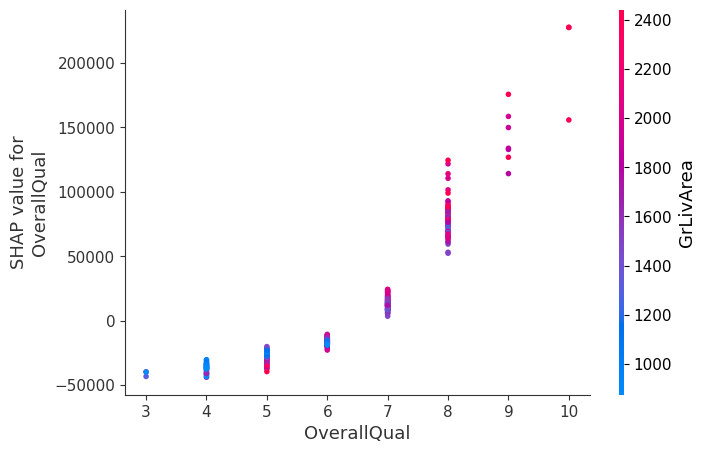

24/08/07 13:25:02 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [20]:
if local_explanations:
    shap.dependence_plot("OverallQual", local_explanations.values, local_explanations.data, feature_names=local_explanations.feature_names)

**Authors**

Developed by Pratap Kishore Varma V